In [2]:
import pandas as pd
import numpy as np
import scipy
import pylab as pl
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
%matplotlib inline

import random
random.seed(1)

In [3]:
# import util file
import sys
# the file path is unique to my machine. ...
sys.path.insert(0,'/Users/arianisfeld/Documents/Presence Health/Healthviz/')
from analytics.util import drop_nan, impute, regression_split, impute_df

AppRegistryNotReady: Apps aren't loaded yet.

In [4]:
def re_df(X,y,w):
    return pd.concat([X,y,w],axis=1)

# random mask of one column

In [4]:
def get_random_mask(df, p=.1, q=np.nan):
    '''
    inputs:
        df (pd.DataFrame or pd.Series,  n x k)
        p (float between 0 and 1) fraction of mask to fill in with q
        q (np.nan or 0) mask value 
    
    returns:
        rand (pd.DataFrame, n x 1) filled with 1 and q.
    '''
    df = pd.DataFrame(df)
    # make random n x k DF 
    rand = df.applymap(lambda x: random.uniform(0, 1))
    # make random n x k DF 
    rand = rand.applymap(lambda x: 1 if x > p else q)
    return rand


def get_test_cols(df,n,exceptions = ["Population (residents), 2011-2015"]):
    x = list(range(df.shape[1]))
    
    for e in exceptions:
        pop = df.columns.get_loc(e)
        x = [y for y in x if y != pop]
    
    random.shuffle(x)
    test_cols = x[:n]
    return test_cols

def get_test_df(df,test_cols=None,n=None, p=.1):
    #prepare random list of columns to mask
    if test_cols is None:
        try:
            test_cols = get_test_cols(df,n)
        except:
            print("must supply input: test_cols or n")
    
    df = df.copy()        
    mask = get_random_mask(df.ix[:,test_cols], p=p)
    #return mask
    df.ix[:,test_cols] = df.ix[:,test_cols]*mask
    return (df, test_cols)
    


In [5]:
# import data
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv',skiprows=0, header=1, index_col=0, encoding='latin_1')
df.index.name=None
# convluded way to drop_nans
df = re_df(*regression_split(df=df,y_name=['Diabetes mortality (deaths per 100,000), 2008-2014'],w_name='Population (residents), 2011-2015'))

In [40]:
def imputation_test(df, y_name=['Diabetes mortality (deaths per 100,000), 2008-2014'],w_name='Population (residents), 2011-2015', n=1, p=.1):
    X,y,w = regression_split(df=df,y_name=y_name, w_name=w_name)
    
    masked_df, test_cols = get_test_df(df,n=n, p=p)
    iX, iy, w = impute_df(data=masked_df,y_name=y_name, sample_weight=w_name)
    
    if iX.shape[0] - X.shape[0]:
        print("Imputated DF different size than original")
    
    imputed_results = sm.WLS(iy, iX, 1/w).fit(cov_type='HC1')
    known_results = sm.WLS(y, X, 1/w).fit(cov_type='HC1')
    test_col_names = df.columns[test_cols]
    return imputed_results, known_results, test_col_names

def difference_in_coefficients(df, y_name=['Diabetes mortality (deaths per 100,000), 2008-2014'],w_name='Population (residents), 2011-2015', n=1, p=.1, full_output = False):
    imp, known, cols = imputation_test(df, y_name, w_name,n,p)
    if full_output:
        print((imp.params[cols] - known.params[cols])/known.params[cols])
        return imp, known
    return (imp.params[cols] - known.params[cols])/known.params[cols]




# running regression imputation (weijie's code)

In [25]:
a,b,c =imputation_test(df)

/Users/arianisfeld/Documents/Presence Health/Healthviz/analytics/util.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_predict['prediction'] = se.values
/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [47]:
l,k = difference_in_coefficients(df,n=5, full_output=True)
display(l.summary())
display(k.summary())


/Users/arianisfeld/Documents/Presence Health/Healthviz/analytics/util.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_predict['prediction'] = se.values
/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Population, Hispanic or Latino (residents), 2011-2015                      10.408783
Public assistance income (cash welfare) (% of households), 2011-2015        0.577005
Age dependency ratio (Dependents per 100 working-age adults), 2011-2015     0.329898
Total election votes (Presidential) (votes), 2016                           4.055990
College graduation rate (% of residents), 2011-2015                        41.991060
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            WLS Regression Results                                            
==============================================================================================================
Dep. Variable:     Diabetes mortality (deaths per 100,000), 2008-2014   R-squared:                       0.891
Model:                                                            WLS   Adj. R-squared:                  0.891
Method:                                                 Least Squares   F-statistic:                     769.1
Date:                                                Mon, 10 Jul 2017   Prob (F-statistic):               0.00
Time:                                                        15:15:10   Log-Likelihood:                -10081.
No. Observations:                                                2482   AIC:                         2.019e+04
Df Residuals:                                                    2467   BIC:                         2.028e+04
Df Model:                                                          15                                         
Covariance Type:                                                  HC1                                         
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
College graduation rate (% of residents), 2011-2015                         0.4869      0.179      2.722      0.006       0.136       0.838
Population, Hispanic or Latino (residents), 2011-2015                   -2.576e-05   1.17e-05     -2.195      0.028   -4.88e-05   -2.76e-06
Total election votes (Presidential) (votes), 2016                        -7.18e-05   1.35e-05     -5.310      0.000   -9.83e-05   -4.53e-05
Public assistance income (cash welfare) (% of households), 2011-2015        0.9121      0.471      1.938      0.053      -0.010       1.835
Age dependency ratio (Dependents per 100 working-age adults), 2011-2015     0.1142      0.053      2.159      0.031       0.011       0.218
Population, Non-Hispanic Black (residents), 2011-2015                    5.928e-05   1.93e-05      3.065      0.002    2.14e-05    9.72e-05
Population, Asian or Pacific Islander (residents), 2011-2015                0.0001   3.11e-05      3.983      0.000    6.29e-05       0.000
Median age, 2011-2015                                                      -0.3660      0.093     -3.954      0.000      -0.547      -0.185
Median household income, 2011-2015                                          0.0002   4.94e-05      5.016      0.000       0.000       0.000
Poverty rate (% of residents), 2011-2015                                    0.6357      0.098      6.505      0.000       0.444       0.827
Share of income, top 5% (% of total income), 2011-2015                      0.4316      0.133      3.241      0.001       0.171       0.693
Dual eligible coverage (% of residents), 2010-2014                         -0.3785      0.423     -0.896      0.370      -1.207       0.450
Graduate education rate (% of residents), 2011-2015                        -1.8434      0.342     -5.397      0.000      -2.513      -1.174
Food stamps (SNAP) (% of households), 2011-2015                             0.3992      0.116      3.444      0.001       0.172       0.626
Election margin, winner (Presidential) (% margin), 2016                     0.0337      0.020      1.662      0.097      -0.006       0.073
==============================================================================
Omnibus:                     1265.344   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            WLS Regression Results                                            
==============================================================================================================
Dep. Variable:     Diabetes mortality (deaths per 100,000), 2008-2014   R-squared:                       0.894
Model:                                                            WLS   Adj. R-squared:                  0.893
Method:                                                 Least Squares   F-statistic:                     964.6
Date:                                                Mon, 10 Jul 2017   Prob (F-statistic):               0.00
Time:                                                        15:15:10   Log-Likelihood:                -9697.1
No. Observations:                                                2482   AIC:                         1.942e+04
Df Residuals:                                                    2467   BIC:                         1.951e+04
Df Model:                                                          15                                         
Covariance Type:                                                  HC1                                         
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Population, Non-Hispanic Black (residents), 2011-2015                    1.386e-05   4.47e-06      3.102      0.002     5.1e-06    2.26e-05
Population, Hispanic or Latino (residents), 2011-2015                   -2.258e-06   3.78e-06     -0.597      0.551   -9.67e-06    5.16e-06
Population, Asian or Pacific Islander (residents), 2011-2015             1.551e-05    7.2e-06      2.154      0.031     1.4e-06    2.96e-05
Median age, 2011-2015                                                      -0.1683      0.093     -1.807      0.071      -0.351       0.014
Age dependency ratio (Dependents per 100 working-age adults), 2011-2015     0.0859      0.046      1.862      0.063      -0.004       0.176
Median household income, 2011-2015                                          0.0002   2.74e-05      7.929      0.000       0.000       0.000
Poverty rate (% of residents), 2011-2015                                    0.5714      0.088      6.517      0.000       0.400       0.743
Share of income, top 5% (% of total income), 2011-2015                      0.2425      0.145      1.667      0.095      -0.043       0.528
Dual eligible coverage (% of residents), 2010-2014                         -0.3363      0.329     -1.023      0.306      -0.980       0.308
College graduation rate (% of residents), 2011-2015                         0.0113      0.128      0.089      0.929      -0.239       0.261
Graduate education rate (% of residents), 2011-2015                        -0.7667      0.227     -3.385      0.001      -1.211      -0.323
Food stamps (SNAP) (% of households), 2011-2015                             0.4011      0.112      3.570      0.000       0.181       0.621
Public assistance income (cash welfare) (% of households), 2011-2015        0.5784      0.302      1.913      0.056      -0.014       1.171
Total election votes (Presidential) (votes), 2016                        -1.42e-05    3.5e-06     -4.062      0.000   -2.11e-05   -7.35e-06
Election margin, winner (Presidential) (% margin), 2016                     0.0389      0.020      1.941      0.052      -0.000       0.078
==============================================================================
Omnibus:                     1244.290   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (

In [50]:
l,k = difference_in_coefficients(df,n=1, full_output=True)
display(l.summary())
display(k.summary())
print((l.params - k.params)/k.params)



Population, Asian or Pacific Islander (residents), 2011-2015    1.040688
dtype: float64


/Users/arianisfeld/Documents/Presence Health/Healthviz/analytics/util.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_predict['prediction'] = se.values
/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            WLS Regression Results                                            
==============================================================================================================
Dep. Variable:     Diabetes mortality (deaths per 100,000), 2008-2014   R-squared:                       0.891
Model:                                                            WLS   Adj. R-squared:                  0.891
Method:                                                 Least Squares   F-statistic:                     822.7
Date:                                                Mon, 10 Jul 2017   Prob (F-statistic):               0.00
Time:                                                        15:36:43   Log-Likelihood:                -10081.
No. Observations:                                                2482   AIC:                         2.019e+04
Df Residuals:                                                    2467   BIC:                         2.028e+04
Df Model:                                                          15                                         
Covariance Type:                                                  HC1                                         
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Population, Asian or Pacific Islander (residents), 2011-2015             4.658e-05   7.72e-05      0.603      0.546      -0.000       0.000
Population, Non-Hispanic Black (residents), 2011-2015                    6.191e-05   1.91e-05      3.239      0.001    2.44e-05    9.94e-05
Population, Hispanic or Latino (residents), 2011-2015                   -2.264e-05   1.45e-05     -1.565      0.118    -5.1e-05    5.71e-06
Median age, 2011-2015                                                      -0.3898      0.091     -4.275      0.000      -0.569      -0.211
Age dependency ratio (Dependents per 100 working-age adults), 2011-2015     0.1411      0.051      2.742      0.006       0.040       0.242
Median household income, 2011-2015                                          0.0003   4.76e-05      5.414      0.000       0.000       0.000
Poverty rate (% of residents), 2011-2015                                    0.6292      0.098      6.443      0.000       0.438       0.821
Share of income, top 5% (% of total income), 2011-2015                      0.4325      0.134      3.226      0.001       0.170       0.695
Dual eligible coverage (% of residents), 2010-2014                         -0.4038      0.424     -0.951      0.341      -1.236       0.428
College graduation rate (% of residents), 2011-2015                         0.3570      0.170      2.095      0.036       0.023       0.691
Graduate education rate (% of residents), 2011-2015                        -1.6095      0.336     -4.790      0.000      -2.268      -0.951
Food stamps (SNAP) (% of households), 2011-2015                             0.3930      0.116      3.384      0.001       0.165       0.621
Public assistance income (cash welfare) (% of households), 2011-2015        0.8682      0.423      2.051      0.040       0.039       1.698
Total election votes (Presidential) (votes), 2016                       -6.112e-05   1.25e-05     -4.899      0.000   -8.56e-05   -3.67e-05
Election margin, winner (Presidential) (% margin), 2016                     0.0306      0.021      1.476      0.140      -0.010       0.071
==============================================================================
Omnibus:                     1282.111   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            WLS Regression Results                                            
==============================================================================================================
Dep. Variable:     Diabetes mortality (deaths per 100,000), 2008-2014   R-squared:                       0.890
Model:                                                            WLS   Adj. R-squared:                  0.889
Method:                                                 Least Squares   F-statistic:                     898.4
Date:                                                Mon, 10 Jul 2017   Prob (F-statistic):               0.00
Time:                                                        15:36:44   Log-Likelihood:                -9782.4
No. Observations:                                                2482   AIC:                         1.959e+04
Df Residuals:                                                    2467   BIC:                         1.968e+04
Df Model:                                                          15                                         
Covariance Type:                                                  HC1                                         
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Population, Non-Hispanic Black (residents), 2011-2015                    1.197e-05   6.07e-06      1.971      0.049    6.44e-08    2.39e-05
Population, Hispanic or Latino (residents), 2011-2015                   -4.842e-06   2.81e-06     -1.725      0.085   -1.03e-05     6.6e-07
Population, Asian or Pacific Islander (residents), 2011-2015             2.283e-05   6.18e-06      3.695      0.000    1.07e-05    3.49e-05
Median age, 2011-2015                                                      -0.2397      0.086     -2.775      0.006      -0.409      -0.070
Age dependency ratio (Dependents per 100 working-age adults), 2011-2015     0.0955      0.052      1.825      0.068      -0.007       0.198
Median household income, 2011-2015                                          0.0002   3.49e-05      6.557      0.000       0.000       0.000
Poverty rate (% of residents), 2011-2015                                    0.6399      0.086      7.408      0.000       0.471       0.809
Share of income, top 5% (% of total income), 2011-2015                      0.2967      0.110      2.700      0.007       0.081       0.512
Dual eligible coverage (% of residents), 2010-2014                          0.0952      0.381      0.250      0.802      -0.651       0.841
College graduation rate (% of residents), 2011-2015                         0.0666      0.118      0.566      0.571      -0.164       0.297
Graduate education rate (% of residents), 2011-2015                        -0.8917      0.216     -4.131      0.000      -1.315      -0.469
Food stamps (SNAP) (% of households), 2011-2015                             0.3754      0.109      3.443      0.001       0.162       0.589
Public assistance income (cash welfare) (% of households), 2011-2015        0.4916      0.414      1.189      0.235      -0.319       1.302
Total election votes (Presidential) (votes), 2016                       -1.438e-05   3.82e-06     -3.763      0.000   -2.19e-05   -6.89e-06
Election margin, winner (Presidential) (% margin), 2016                     0.0082      0.017      0.476      0.634      -0.026       0.042
==============================================================================
Omnibus:                     1363.123   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (

Age dependency ratio (Dependents per 100 working-age adults), 2011-2015    0.477950
College graduation rate (% of residents), 2011-2015                        4.361125
Dual eligible coverage (% of residents), 2010-2014                        -5.241141
Election margin, winner (Presidential) (% margin), 2016                    2.722430
Food stamps (SNAP) (% of households), 2011-2015                            0.046948
Graduate education rate (% of residents), 2011-2015                        0.804958
Median age, 2011-2015                                                      0.626640
Median household income, 2011-2015                                         0.126224
Population, Asian or Pacific Islander (residents), 2011-2015               1.040688
Population, Hispanic or Latino (residents), 2011-2015                      3.676006
Population, Non-Hispanic Black (residents), 2011-2015                      4.172229
Poverty rate (% of residents), 2011-2015                                  -0

# Using statsmodels MICE

In [59]:
from statsmodels.imputation import mice

In [131]:
full_df = pd.read_csv('HealthViz County Dataset 6 21 17.csv',header=0, skiprows=[1],index_col=0,encoding='latin_1')
full_df.index.name=None
full_df.drop(["County"], axis=1, inplace=True)
full_df.head()
#full_df.

,MYH_2008-2014,POP_2011-2015,POP-B_2011-2015,POP-H_2011-2015,POP-A_2011-2015,AGE_2011-2015,DEP_2011-2015,INC_2011-2015,POV_2011-2015,INQ_2011-2015,DUA_2010-2014,EDE_2011-2015,EDF_2011-2015,SNP_2011-2015,TNF_2011-2015,EEC_2016,EEG_2016
1001,21.5,55221,10315,1440,534,37.7,63.865397,51219.97561,12.879382,18.51,2.164335,23.230265,9.746964,13.777211,2.603452,24661.0,49.478934
1003,17.5,195121,18735,8776,1307,42.2,68.057087,50194.19774,13.411661,20.90,1.676687,28.985190,9.724017,9.003563,2.238746,94090.0,57.786162
1005,19.4,26932,12595,1241,244,38.8,59.653803,32924.77284,26.727439,18.70,4.737949,12.515951,5.008507,25.970505,1.984385,10390.0,5.611165
1007,24.5,22604,4846,502,21,38.9,56.645877,38631.97318,16.795878,21.11,4.483200,10.646874,4.594024,15.781984,7.599260,8748.0,55.544124
1009,13.8,57710,884,4980,83,40.7,67.207510,45758.48253,16.720933,16.23,3.031681,12.890784,4.273244,13.489623,1.104919,25384.0,81.381973


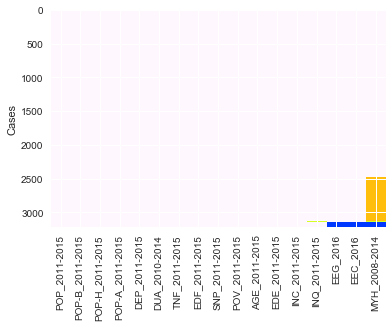

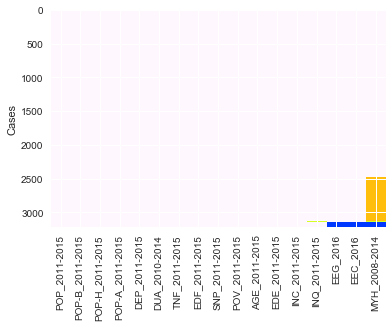

In [133]:
a = mice.MICEData(full_df)
#a.plot_missing_pattern()

In [116]:
full_df.head()

,MYH_2008-2014,POP_2011-2015,POP-B_2011-2015,POP-H_2011-2015,POP-A_2011-2015,AGE_2011-2015,DEP_2011-2015,INC_2011-2015,POV_2011-2015,INQ_2011-2015,DUA_2010-2014,EDE_2011-2015,EDF_2011-2015,SNP_2011-2015,TNF_2011-2015,EEC_2016,EEG_2016
1001,21.5,55221,10315,1440,534,37.7,63.8653966,51219.97561,12.8793824,18.51,2.164334569,23.23026515,9.746964399,13.77721122,2.603451657,24661,49.47893435
1003,17.5,195121,18735,8776,1307,42.2,68.05708675,50194.19774,13.41166073,20.9,1.676687272,28.98518989,9.724016613,9.003562561,2.238745547,94090,57.78616219
1005,19.4,26932,12595,1241,244,38.8,59.65380283,32924.77284,26.72743923,18.7,4.737948951,12.51595066,5.008507018,25.97050531,1.984385166,10390,5.611164581
1007,24.5,22604,4846,502,21,38.9,56.64587665,38631.97318,16.79587808,21.11,4.483199848,10.6468744,4.59402393,15.78198378,7.599259997,8748,55.54412437
1009,13.8,57710,884,4980,83,40.7,67.20751,45758.48253,16.72093268,16.23,3.031681332,12.8907836,4.273244011,13.48962337,1.104919293,25384,81.3819729


In [155]:
masked_df, test_cols = get_test_df(df,n=3, p=.1)
b = mice.MICEData(masked_df)
#b.plot_missing_pattern()
b.data.columns[test_cols]

Index(['Poverty rate (% of residents), 2011-2015',
       'Election margin, winner (Presidential) (% margin), 2016',
       'Food stamps (SNAP) (% of households), 2011-2015'],
      dtype='object')

PatsyError: numbers besides '0' and '1' are only allowed with **
    Poverty rate (% of residents), 2011-2015 ~ Population, Non-Hispanic Black (residents), 2011-2015 + Population, Hispanic or Latino (residents), 2011-2015 + Population, Asian or Pacific Islander (residents), 2011-2015 + Median age, 2011-2015 + Age dependency ratio (Dependents per 100 working-age adults), 2011-2015 + Median household income, 2011-2015 + Share of income, top 5% (% of total income), 2011-2015 + Dual eligible coverage (% of residents), 2010-2014 + College graduation rate (% of residents), 2011-2015 + Graduate education rate (% of residents), 2011-2015 + Food stamps (SNAP) (% of households), 2011-2015 + Public assistance income (cash welfare) (% of households), 2011-2015 + Total election votes (Presidential) (votes), 2016 + Election margin, winner (Presidential) (% margin), 2016 + Diabetes mortality (deaths per 100,000), 2008-2014 + Population (residents), 2011-2015
                                        ^^^^

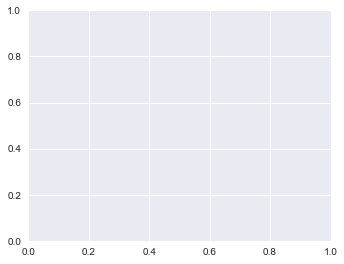

In [156]:
b.plot_fit_obs('Poverty rate (% of residents), 2011-2015')

In [160]:
b=mice.MICEData(df)
j = 0
for data in b:
    b.data.to_csv('data%02d.csv' % j)
    j += 1

TypeError: 'MICEData' object is not iterable